In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import string
from tqdm import tqdm

In [ ]:
def load_captions(filename):
    descriptions = {}
    with open(filename, 'r') as file:
        next(file)  # Skip the first line (header)
        for line in file:
            tokens = line.strip().split(',')
            image_id, caption = tokens[0], ",".join(tokens[1:])  # Handle commas in captions
            image_id = image_id.split('.')[0]  # Remove file extension

            # Clean caption (convert to lowercase, remove punctuation)
            caption = caption.lower().translate(str.maketrans("", "", string.punctuation))
            caption = f"<start> {caption} <end>"
            # Store in dictionary
            if image_id not in descriptions:
                descriptions[image_id] = []
            descriptions[image_id].append(caption)

    return descriptions

descriptions = load_captions("/content/drive/MyDrive/Image Captioning Model Project/captions.txt")
# Printing to see what descriptions look like
print("Captions loaded successfully!")
for img_id, caps in list(descriptions.items())[:5]:
    print(f"Image ID: {img_id}")
    for cap in caps:
        print(f"  - {cap}")


Captions loaded successfully!
Image ID: 1000268201_693b08cb0e
  - <start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>
  - <start> a girl going into a wooden building  <end>
  - <start> a little girl climbing into a wooden playhouse  <end>
  - <start> a little girl climbing the stairs to her playhouse  <end>
  - <start> a little girl in a pink dress going into a wooden cabin  <end>
Image ID: 1001773457_577c3a7d70
  - <start> a black dog and a spotted dog are fighting <end>
  - <start> a black dog and a tricolored dog playing with each other on the road  <end>
  - <start> a black dog and a white dog with brown spots are staring at each other in the street  <end>
  - <start> two dogs of different breeds looking at each other on the road  <end>
  - <start> two dogs on pavement moving toward each other  <end>
Image ID: 1002674143_1b742ab4b8
  - <start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <end>
  - <sta

In [ ]:
# Load image features
with open("/content/drive/MyDrive/Image Captioning Model Project/image_features.pkl", "rb") as f:
    image_features = pickle.load(f)

print("Image features loaded successfully!")
# Printing top 5 values to see what image_features looks like
count = 0
for key, value in image_features.items():
    print(key, value)
    count += 1
    if count == 5:
        break

Image features loaded successfully!
1000268201_693b08cb0e [1.9046054 0.        0.        ... 0.        0.        0.       ]
1001773457_577c3a7d70 [0.         0.         0.28391886 ... 0.         0.         0.        ]
1002674143_1b742ab4b8 [1.5989008 0.        0.        ... 2.5635054 2.6149707 0.       ]
1003163366_44323f5815 [0. 0. 0. ... 0. 0. 0.]
1007129816_e794419615 [0.        0.3743969 0.        ... 0.        0.        0.       ]


In [ ]:
def create_tokenizer(descriptions):
    all_captions = [caption for captions in descriptions.values() for caption in captions]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

# Tokenize captions
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(cap.split()) for caps in descriptions.values() for cap in caps)
print(f"Vocabulary size: {vocab_size}, Max sequence length: {max_length}")

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size=32):
    """
    Generator to yield batches of training data.
    For each caption, we create multiple input-output pairs:
      - Input 1: image feature vector
      - Input 2: padded input sequence of words
      - Output: one-hot encoded next word
    """
    image_ids = list(descriptions.keys())
    n = len(image_ids)
    i = 0
    while True:
        X1, X2, y = [], [], []
        for _ in range(batch_size):
            if i == n:
                i = 0
            image_id = image_ids[i]
            i += 1
            # Get the image feature vector
            feature = features[image_id]
            # Process each caption for the image
            for caption in descriptions[image_id]:
                # Convert caption to sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Create input-output pairs using sliding window approach
                for j in range(1, len(seq)):
                    in_seq = seq[:j]
                    out_seq = seq[j]
                    # Pad input sequence to fixed length
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # One-hot encode the output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Append to batch
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    if len(X1) >= batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []

In [ ]:
from tensorflow.keras.layers import add
def define_model(vocab_size, max_length):
    # Image feature input (assuming feature vector size 4096)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Caption input (word sequences)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder: combine image and caption features
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 256)   │  2,260,224 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 38, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 38)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8829)      │  2,269,053 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,169,213 (23.53 MB)

 Trainable params: 6,169,213 (23.53 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
def train_model(model, descriptions, image_features, tokenizer, max_length, vocab_size, epochs=20, batch_size=32):
    # Calculate steps per epoch
    total_samples = sum(len(caption.split()) - 1 for captions in descriptions.values() for caption in captions)
    steps = total_samples // batch_size

    # Create data generator
    generator = data_generator(descriptions, image_features, tokenizer, max_length, vocab_size, batch_size)

    # Setup callbacks for better training
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

    checkpoint = ModelCheckpoint('/content/drive/MyDrive/Image Captioning Model Project/best_model.keras',
                                save_best_only=True,
                                monitor='loss',
                                mode='min')

    early_stopping = EarlyStopping(patience=5,
                                  monitor='loss',
                                  restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='loss',
                                 factor=0.2,
                                 patience=2,
                                 min_lr=0.00001)

    # Train the model
    history = model.fit(generator,
                      epochs=epochs,
                      steps_per_epoch=steps,
                      callbacks=[checkpoint, early_stopping, reduce_lr],
                      verbose=1)

    return model, history

In [ ]:
model, history = train_model(model, descriptions, image_features, tokenizer, max_length, vocab_size)

Epoch 1/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 183s 12ms/step - loss: 4.4075 - learning_rate: 0.0010
Epoch 2/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 178s 12ms/step - loss: 3.5158 - learning_rate: 0.0010
Epoch 3/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 180s 12ms/step - loss: 3.3124 - learning_rate: 0.0010
Epoch 4/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - loss: 3.2499 - learning_rate: 0.0010
Epoch 5/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - loss: 3.1789 - learning_rate: 0.0010
Epoch 6/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 177s 12ms/step - loss: 3.1442 - learning_rate: 0.0010
Epoch 7/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 180s 12ms/step - loss: 3.1335 - learning_rate: 0.0010
Epoch 8/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 178s 12ms/step - loss: 3.1081 - learning_rate: 0.0010
Epoch 9/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - loss: 3.0984 - learning_rate: 0.0010
Epoch 10/20
14905/14905 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - loss: 3.0935 - learning_rate: 0.0010
Epoch 11/20
14905/1

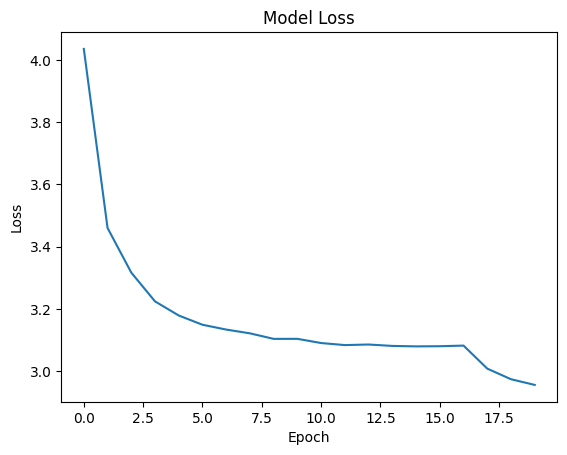

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
def save_model(model, tokenizer, max_length):
    # Save model
    model_path = '/content/drive/MyDrive/Image Captioning Model Project/image_captioning_model_best.keras'
    model.save(model_path)

    # Save tokenizer
    tokenizer_path = '/content/drive/MyDrive/Image Captioning Model Project/tokenizer_best.pkl'
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)

    # Save max_length
    max_length_path = '/content/drive/MyDrive/Image Captioning Model Project/max_length_best.pkl'
    with open(max_length_path, 'wb') as f:
        pickle.dump(max_length, f)

    print(f"Model saved to {model_path}")
    print(f"Tokenizer saved to {tokenizer_path}")
    print(f"Max length saved to {max_length_path}")

save_model(model, tokenizer, max_length)

Model saved to /content/drive/MyDrive/Image Captioning Model Project/image_captioning_model_best.keras
Tokenizer saved to /content/drive/MyDrive/Image Captioning Model Project/tokenizer_best.pkl
Max length saved to /content/drive/MyDrive/Image Captioning Model Project/max_length_best.pkl
